In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import module as m

In [95]:
current_dir = os.getcwd()
dir = 'csv_filtrered'
csv_dir = os.path.join(current_dir, dir)
csv_files = [os.path.join(dir, f) for f in os.listdir(dir) if f.endswith('.csv')]

current_dir = os.getcwd()
dir = 'GRD'
grd_dir = os.path.join(current_dir, dir)
grd_files = [os.path.join(dir, f) for f in os.listdir(dir) if f.endswith('.grd')]

# Предподготовка

теперь на каждый график добавим время прихода атмосферной волны и атмосферной

In [96]:
info = pd.read_csv('info_file.csv')

In [101]:
find_code = lambda text: text.split('/')[1].split('_')[0]
find_grd = lambda text: text.split('/')[1].split('.')[0]

codes = [find_code(i) for i in csv_files]

In [102]:
df = pd.DataFrame({
    'code' : codes,
    'files' : csv_files,
    'lat' : info['lat'],
    'lon1' : info['lon'],
    'lon2' : (info['lon'] + 360)%360 #перевод в 360-градусную систему, так как используется на карте такое
})

In [103]:
grd_links = []

for index, row in df.iterrows():
    for i in grd_files:
        if row['code'] == find_grd(i):
            grd_links.append(i)
            break
    if row['code'] != find_grd(grd_links[-1]):
        grd_links.append(np.nan)

df['grd_links'] = grd_links
df['csv_links'] = csv_files

In [104]:
df.head()

,code,files,lat,lon1,lon2,grd_links,csv_links
0,sdpt,csv_filtrered/sdpt_Sand Point.csv,31.58,131.41,131.41,GRD/sdpt.grd,csv_filtrered/sdpt_Sand Point.csv
1,yaku2,csv_filtrered/yaku2_Yakutat.csv,27.02,142.19,142.19,NaN,csv_filtrered/yaku2_Yakutat.csv
2,anch2,csv_filtrered/anch2_Anchorage.csv,24.33,124.16,124.16,GRD/anch2.grd,csv_filtrered/anch2_Anchorage.csv
3,atka,csv_filtrered/atka_Atka. AK.csv,33.48,135.77,135.77,NaN,csv_filtrered/atka_Atka. AK.csv
4,kush,csv_filtrered/kush_Kushiro.csv,42.98,144.37,144.37,GRD/kush.grd,csv_filtrered/kush_Kushiro.csv


Станции невошедшие в выборку из-за отсутствия grd_links:

yaku2, 
atka, 
sdpt2

In [105]:
df = df.dropna() # удаление пустых

# Вычисление времени добегания волн

In [127]:
#вычислим на каком пикселе находится вулкан

#169/2550 с 120 по lon
#160/2400 c -80 по lat

x = np.argmin(np.abs(np.linspace(120, 290, 2550) - 184.633))
y = np.argmin(np.abs(np.linspace(-80, 80, 2400) - -20.533)) + 1

x, y

(969, 893)

In [128]:
air_times = []
water_times = []
for index, row in df.iterrows():
    air_time = m.distance(row['lat'], row['lon1'], -20.5333, 184.6333) / 1116
    air_times.append(air_time)

    DATA = m.get_data(row['grd_links'])
    water_times.append(DATA[y][x])

df['air'] = air_times
df['water'] = water_times

In [129]:
df.head()

,code,files,lat,lon1,lon2,grd_links,csv_links,air,water
0,sdpt,csv_filtrered/sdpt_Sand Point.csv,31.58,131.41,131.41,GRD/sdpt.grd,csv_filtrered/sdpt_Sand Point.csv,7.250980,6.7248
2,anch2,csv_filtrered/anch2_Anchorage.csv,24.33,124.16,124.16,GRD/anch2.grd,csv_filtrered/anch2_Anchorage.csv,7.363109,12.2168
4,kush,csv_filtrered/kush_Kushiro.csv,42.98,144.37,144.37,GRD/kush.grd,csv_filtrered/kush_Kushiro.csv,7.304592,5.8595
5,adak,csv_filtrered/adak_Adak.csv,34.92,139.83,139.83,GRD/adak.grd,csv_filtrered/adak_Adak.csv,6.945339,5.2562
6,yaku,csv_filtrered/yaku_Yakutat.csv,39.02,141.75,141.75,GRD/yaku.grd,csv_filtrered/yaku_Yakutat.csv,7.135268,7.9580


In [130]:
def paint(link, air, water):
    air += 4.25
    water += 4.25
    
    df = pd.read_csv(link)
    plt.figure(figsize=(18, 5))
    x = df.iloc[:, 0] * 24  
    y = df.iloc[:, 1]
    y /= max(y) #нормируем на 1

    plt.plot([air, air], [-1, 1], label='air')
    plt.plot([water, water], [-1, 1], label='water')
    plt.legend()
    plt.xlim(-3, 20)
    
    plt.plot(x, y)

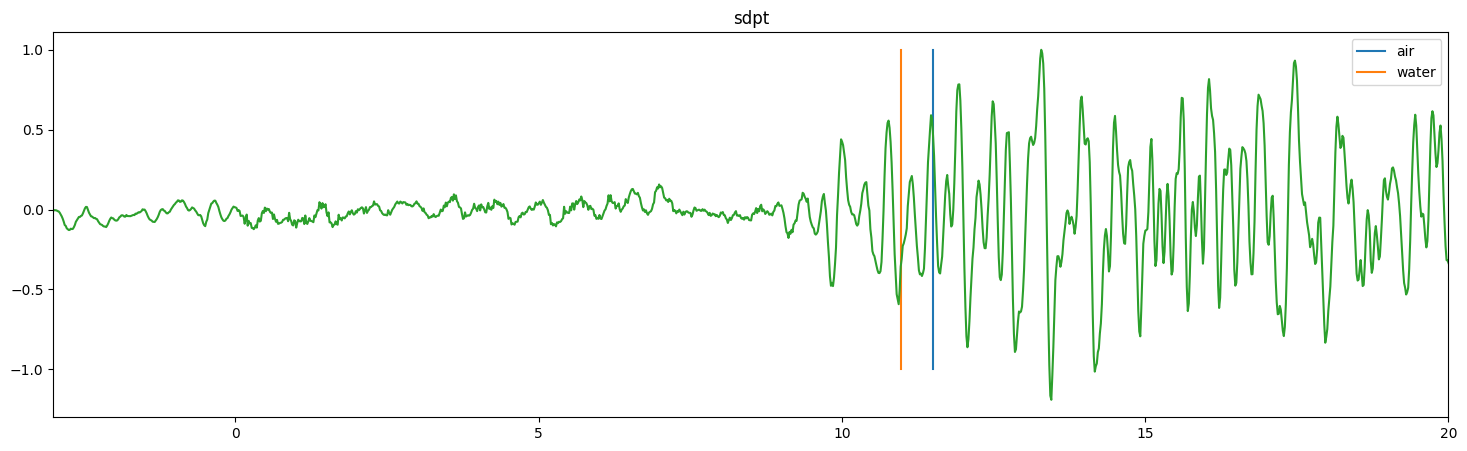

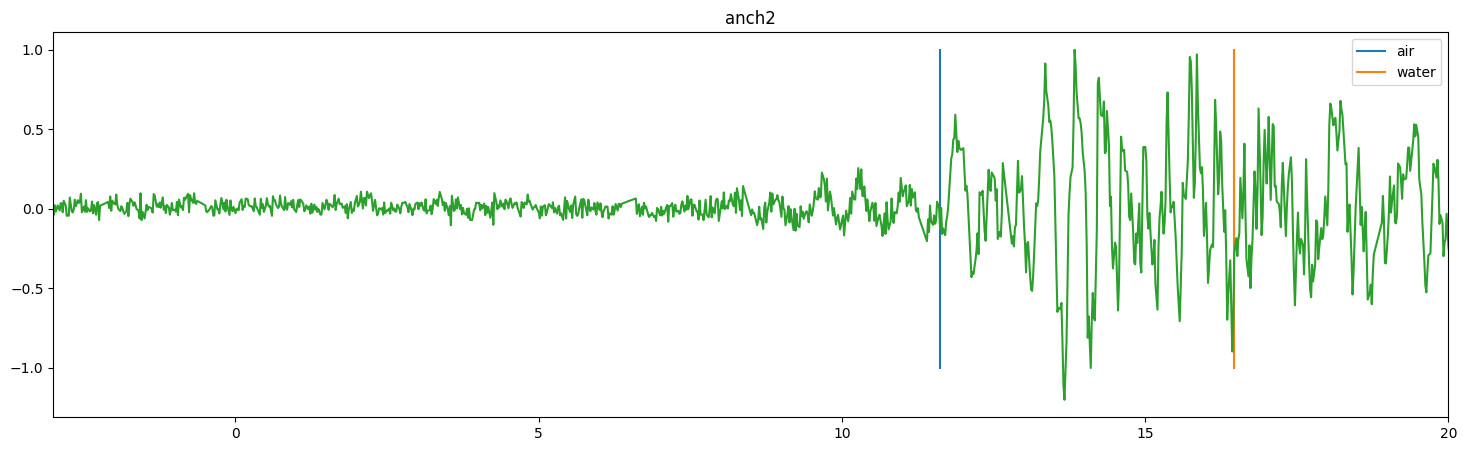

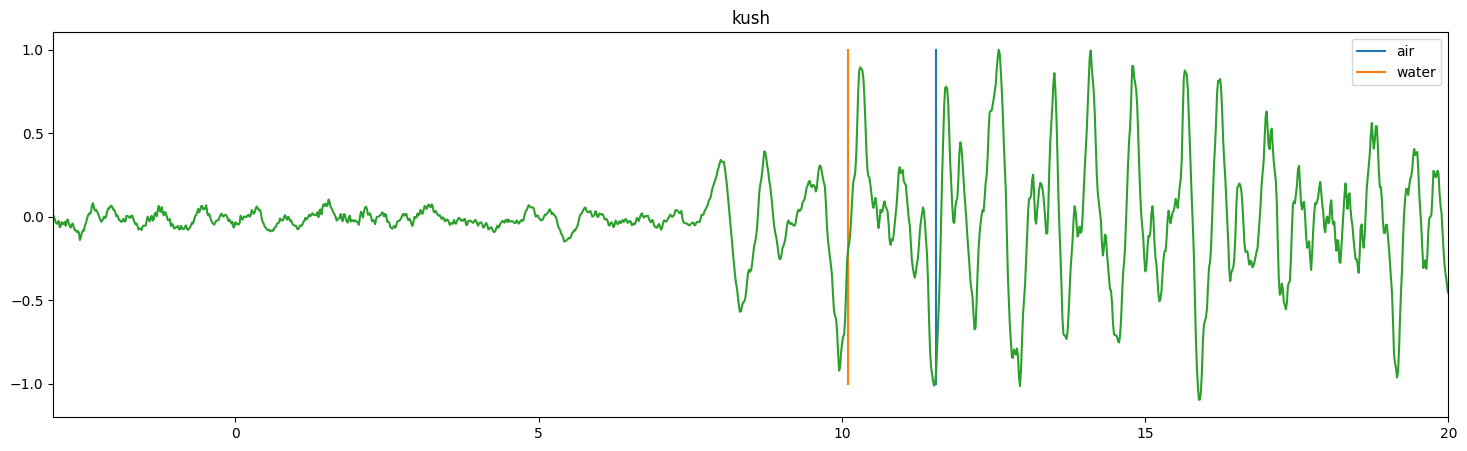

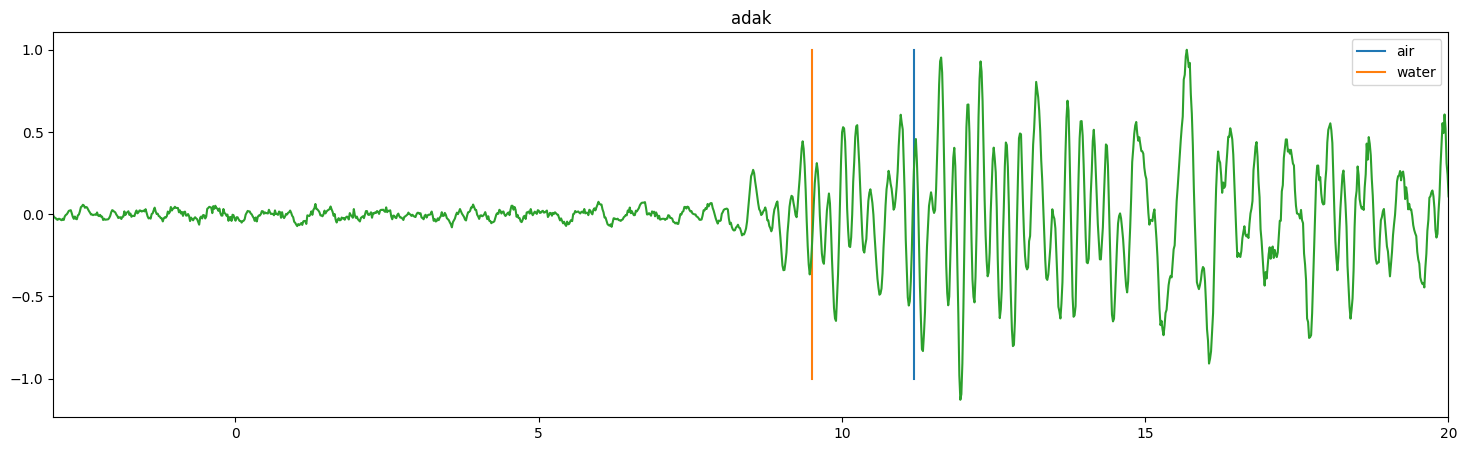

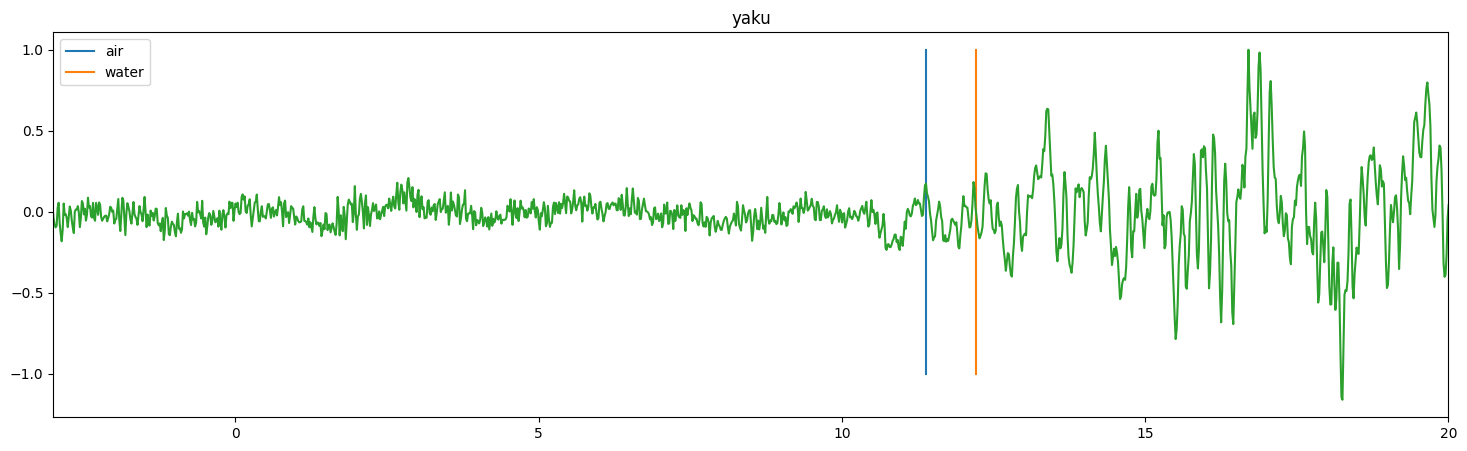

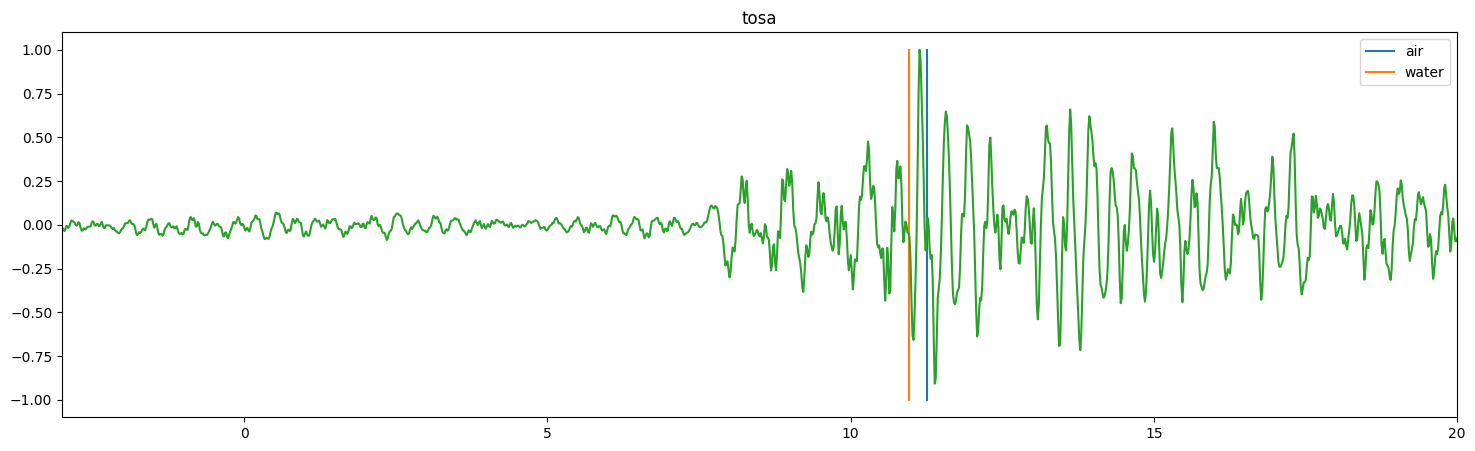

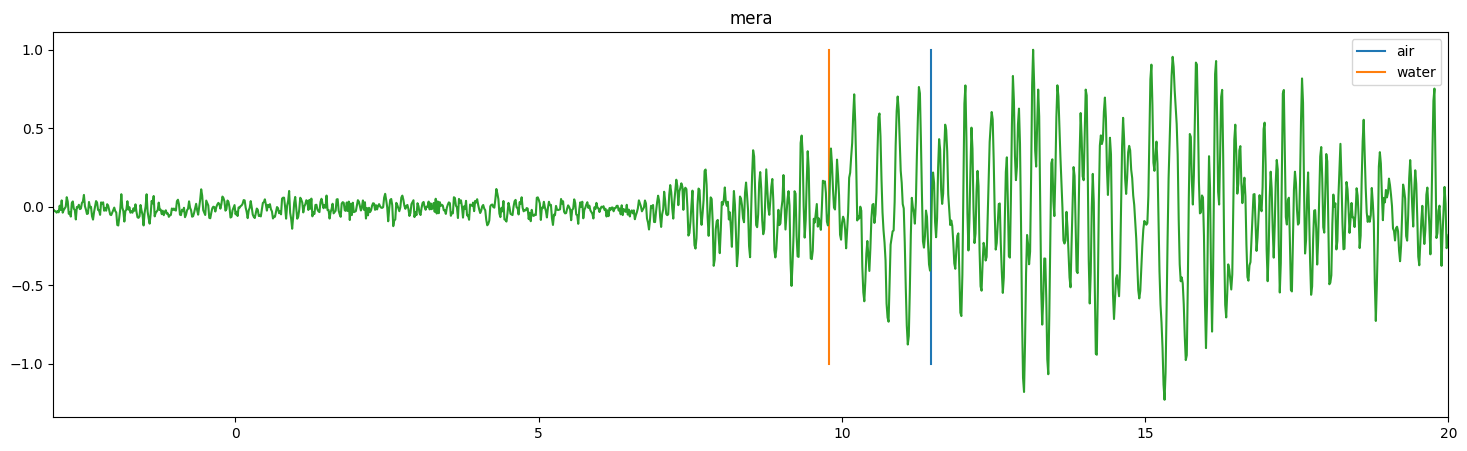

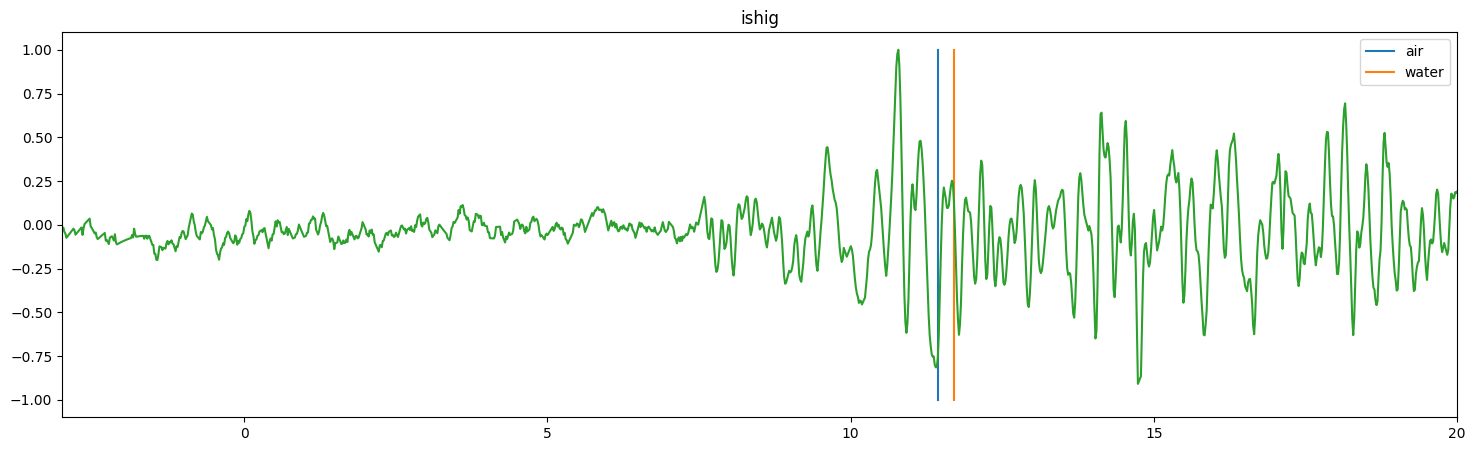

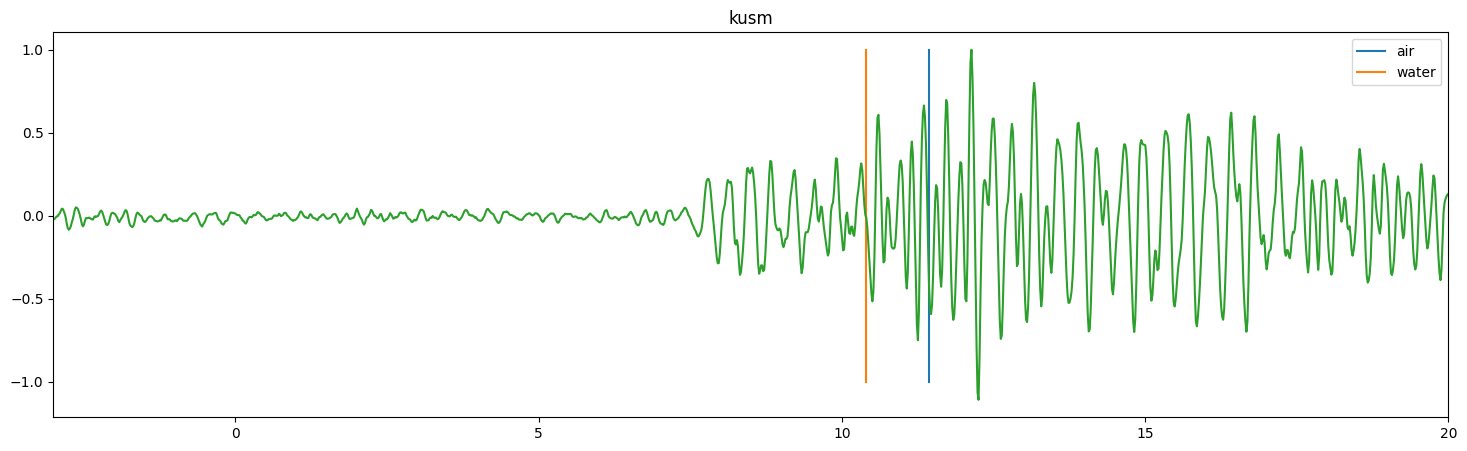

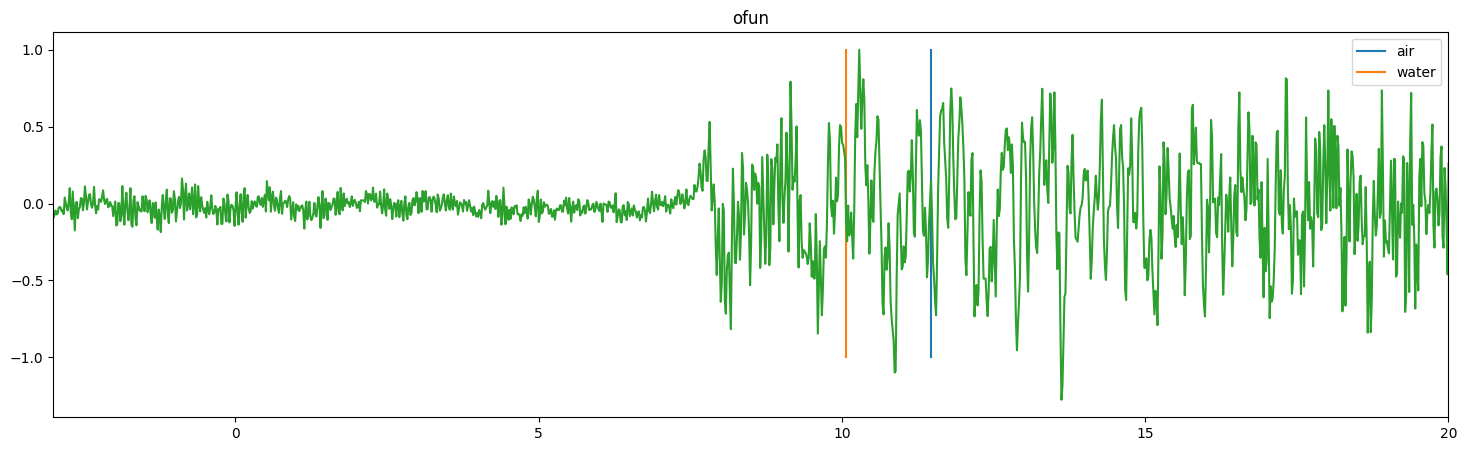

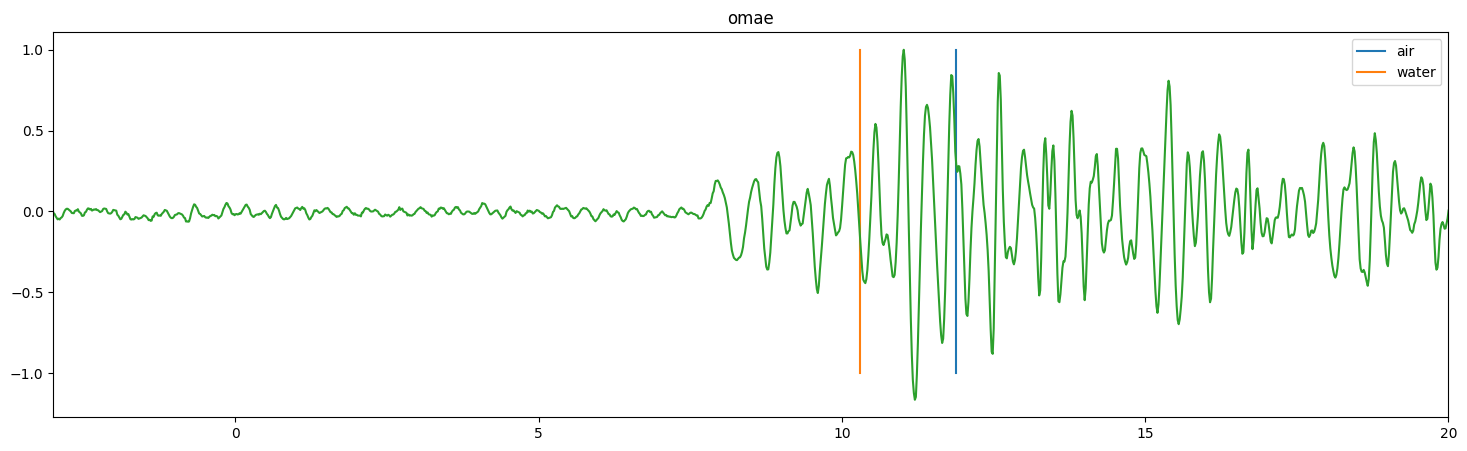

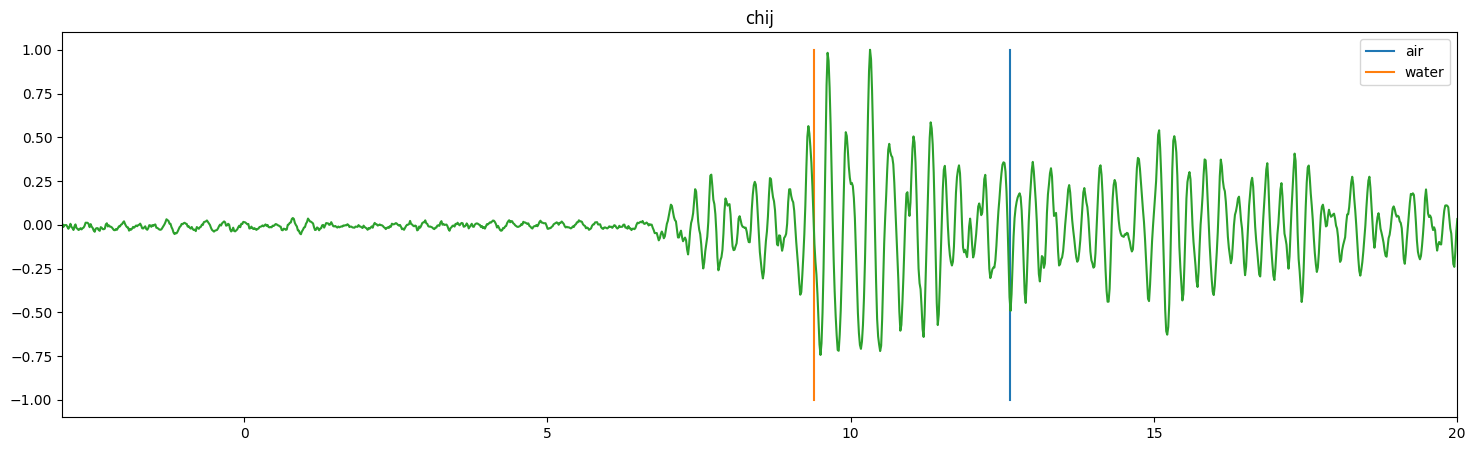

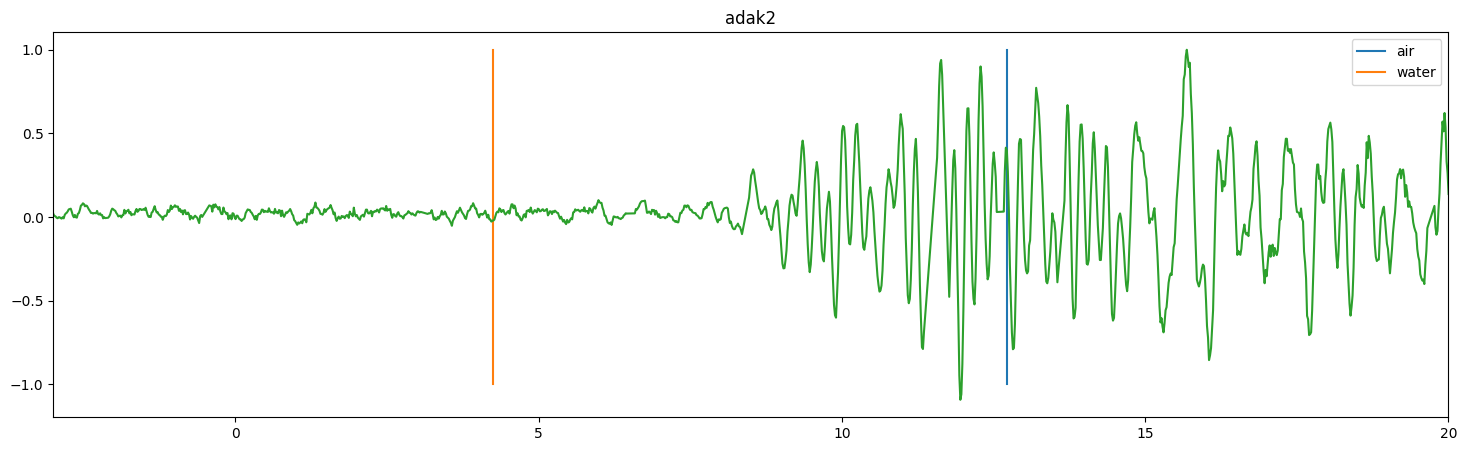

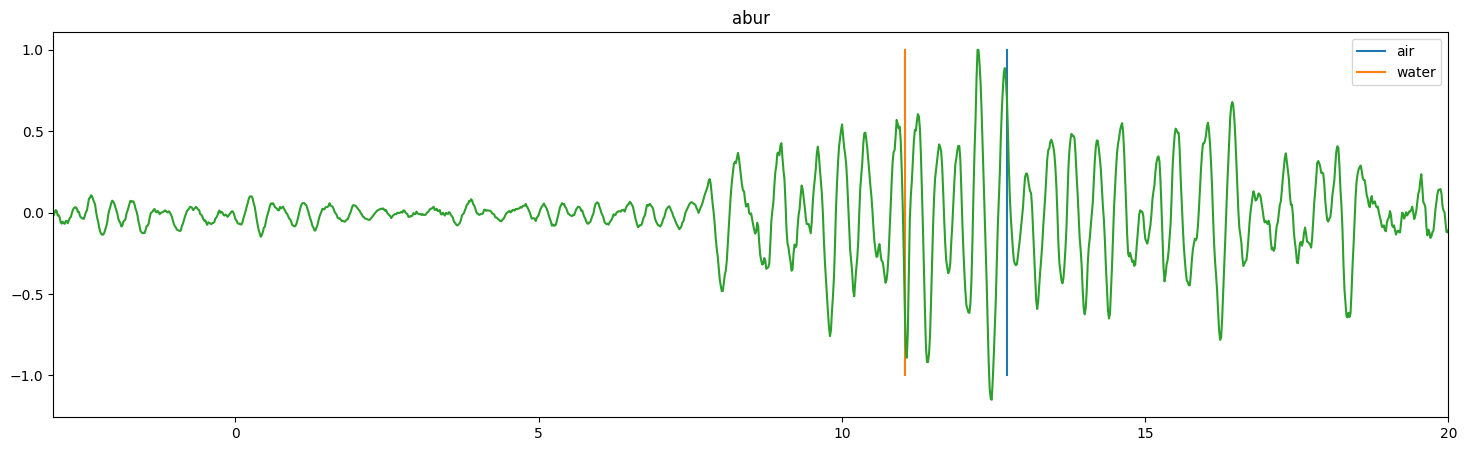

In [131]:
for index, row in df.iterrows():
    paint(row['csv_links'], row['air'], row['water'])
    plt.title(row['code'])
    plt.show()